In [2]:
pip install plotly

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [88]:
import numpy as np 
from scipy.stats import norm
from math import log, sqrt, exp
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

import pandas as pd



In [4]:
def bs_call_price(S, K, r, sigma, t, T):
    """
    Black–Scholes formula for a European call option.
    S: current underlying price
    K: strike
    r: risk-free rate
    sigma: volatility
    t: current time
    T: maturity time
    """
    tau = T - t  # time to maturity
    if tau <= 0:
        return max(S - K, 0)  # option payoff at/after maturity
    
    d1 = (log(S/K) + (r + 0.5*sigma**2)*tau) / (sigma*sqrt(tau))
    d2 = d1 - sigma*sqrt(tau)
    
    call = S*norm.cdf(d1) - K*exp(-r*tau)*norm.cdf(d2)
    return call

def bs_call_delta(S, K, r, sigma, t, T):
    """
    Delta for a European call option (partial derivative of price wrt S).
    """
    tau = T - t
    if tau <= 0:
        return (S>K)* 1.0
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*tau) / (sigma*np.sqrt(tau))
    return norm.cdf(d1)


In [5]:

# ------------------------------
# Parameters for the simulation
# ------------------------------
S0 = 100.0      # initial underlying price
K  = 100.0      # strike
r  = 0.02       # annual risk-free rate
sigma = 0.20    # volatility (20%)
T  = 1.0        # maturity in years (1 year)
steps = 20     # number of discrete hedging steps
dt = T / steps  # length of each time step
nb_simul = 10000
costs = [0.0,0.001,0.002,0.005]



 ...]

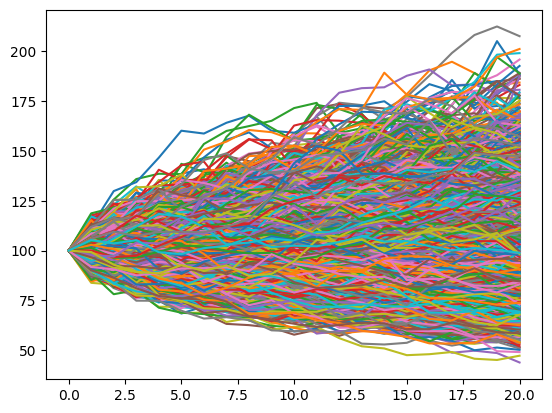

In [6]:
#Simulated path 
def simulation_path(S0,K,r,sigma,steps,nb_simul):
    times = np.linspace(0, T, steps+1)
    Z = np.random.normal(0,1,(nb_simul,steps+1))
    Z = np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    Z[:,0]=S0
    Z = Z.cumprod(axis = 1)
    return(Z.T)
plt.plot(simulation_path(S0,K,r,sigma,steps,nb_simul))

In [7]:
"""
# ----------------------
# Delta-hedging
# ----------------------
# We SELL 1 call option at t=0, so we get its premium initially.
premium = bs_call_price(S0, K, r, sigma, 0.0, T)"""
final_portfolios_values = []
for cost in costs : 
    # Our hedge: we hold Delta shares of the underlying (continuously updated).
    # Start: compute initial delta at t=0
    delta_old = bs_call_delta(S0, K, r, sigma, 0.0, T)
    premium = bs_call_price(S0, K, r, sigma, 0.0, T)
    # We'll track the value of our hedging portfolio:
    #   - "option value" is negative (we sold the call).
    #   - "stock holding" is delta shares.
    #   - "cash" starts with the option premium minus the cost to buy delta shares.
    portfolio_value = premium - delta_old*S0
    # To keep track of PnL, note that at each step we:
    #  - Revalue the option
    #  - Rebalance the hedge (update delta)
    #  - Gains/losses go into portfolio_value
    for i in range(1, steps+1):
        t = times[i]
        # New delta
        delta_new = bs_call_delta(Z[:,i], K, r, sigma, t, T)
        
        # Rebalance cost: We go from delta_old shares to delta_new shares.
        # The price of the shares is S[i]. 
        # So the immediate cashflow from rebalancing is: (delta_old - delta_new)*S[i]
        # (If delta_new > delta_old, we are buying shares, so we spend money (negative).)
        rebalance_cashflow = (delta_old - delta_new)*Z[:,i] - cost*np.abs((delta_old - delta_new)*Z[:,i])
        
        # Update portfolio value by that cashflow
        portfolio_value += rebalance_cashflow
        # Move forward in time: accrue risk-free interest over dt
        # (Very rough discrete approximation: portfolio_value *= exp(r*dt))
        # We'll do that only if we want to incorporate interest on any cash part:
        portfolio_value *= exp(r*dt)
        
        # Update old delta
        delta_old = delta_new

    # ---------------------------
    # Final payout of the option
    # ---------------------------
    # At maturity, the call option we sold costs us: payoff = max(S(T) - K, 0).
    final_option_payoff = (Z[:,-1]-K >0)*(Z[:,-1]-K) 

    # The final stock holding is delta_old shares worth delta_old * S[-1].
    # We can liquidate them at maturity. So the final net in the portfolio is:
    final_portfolio_value = portfolio_value + delta_old * Z[:,-1] - final_option_payoff -cost*delta_old * Z[:,-1]
    final_portfolios_values.append(final_portfolio_value)

NameError: name 'times' is not defined

In [7]:
pip install nbformat==4.2.0

  Attempting uninstall: nbformat
    Found existing installation: nbformat 5.10.4
    Uninstalling nbformat-5.10.4:
      Successfully uninstalled nbformat-5.10.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-server 2.14.2 requires nbformat>=5.3.0, but you have nbformat 4.2.0 which is incompatible.
nbclient 0.10.0 requires nbformat>=5.1, but you have nbformat 4.2.0 which is incompatible.
nbconvert 7.16.4 requires nbformat>=5.7, but you have nbformat 4.2.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [8]:
import plotly.graph_objects as go


In [9]:
fig = go.Figure()
for i in range(len(costs)):

    fig.add_trace(go.Histogram(x=final_portfolios_values[i]))

# Overlay both histograms
fig.update_layout(barmode = 'overlay')
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.show()

IndexError: list index out of range

# Make the plot for delta for different time to maturity and different stike 

# try to construct a small neural network that takes time to matuirity and moneyness and get the delta 

In [42]:
# We areg goin to construct a small neural networks that takes in input time to matuirity and moneyness and get the delta back 
# First we construct our train set 
# We are going to try with 20 periods 
S = simulation_path(S0,K,r,sigma,steps,nb_simul)
ttm = list(np.linspace(0,20,21,dtype ='int'))
l = [[time,s] for (time,s) in zip(ttm,S)]
dataset = np.zeros(((steps+1)*nb_simul,5))

In [43]:
dataset[:,0] = ttm*nb_simul
dataset[:,1] = S.T.reshape(210000,)
dataset[:,2] = r
dataset[:,3] = sigma
dataset[:,4] = [bs_call_delta(dataset[i,1],K,r,sigma,dataset[i,0],20) for i in range((nb_simul*(steps+1)))]


In [44]:
dataset[:,1] = np.log(dataset[:,1]/K)

# Buil a neural network to predict y 

In [166]:
X_train = dataset[:200000,:2]
Y_train = dataset[:200000,4]
X_test = dataset[200000:,:2]
Y_test = dataset[200000:,4]

In [167]:
X_train

array([[ 0.        ,  0.        ],
       [ 1.        ,  0.06039478],
       [ 2.        ,  0.0594671 ],
       ...,
       [14.        ,  0.17196612],
       [15.        ,  0.24945991],
       [16.        ,  0.1688031 ]])

In [169]:

model = keras.Sequential([
    layers.Dense(32,input_shape=(2,)),  
    layers.BatchNormalization(),                         
    layers.Activation('relu'),
    layers.Dropout(0.2),

    layers.Dense(64, use_bias=False),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.2),

    layers.Dense(32, use_bias=False),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.2),

    # Output layer with 1 neuron (sigmoid -> output in [0, 1])
    layers.Dense(1, activation='sigmoid')
])

def custom_loss(y_true, y_pred):
    # Example: Mean Squared Error with an additional penalty
    mse = tf.reduce_mean(tf.square(y_pred- y_true))

     # Add a penalty term
    return mse + 0.01* tf.sqrt((tf.reduce_mean(tf.square(y_pred)) - tf.square(tf.reduce_mean(y_pred))))

# 3. Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=custom_loss,
              metrics=['accuracy'])

# 4. Train the model
history = model.fit(
    X_train, Y_train,
    epochs=5,
    batch_size=128,
    validation_split=0.2,  # 20% of data for validation
    verbose=1
)

# 5. Evaluate on the entire dataset
loss, accuracy = model.evaluate(X, Y, verbose=0)
print(f"Final Training Loss: {loss:.4f}")
print(f"Final Training Accuracy: {accuracy:.4f}")


Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 24s 17ms/step - accuracy: 0.0385 - loss: 0.0211 - val_accuracy: 0.0475 - val_loss: 0.0047
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - accuracy: 0.0452 - loss: 0.0064 - val_accuracy: 0.0475 - val_loss: 0.0034
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accuracy: 0.0456 - loss: 0.0052 - val_accuracy: 0.0446 - val_loss: 0.0032
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accuracy: 0.0444 - loss: 0.0042 - val_accuracy: 0.0436 - val_loss: 0.0037
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.0462 - loss: 0.0036 - val_accuracy: 0.0475 - val_loss: 0.0023
Final Training Loss: 0.0022
Final Training Accuracy: 0.0475


In [140]:
X_test

array([[17.        ,  0.10719165,  0.02      ,  0.2       ],
       [18.        ,  0.07665381,  0.02      ,  0.2       ],
       [19.        ,  0.03522005,  0.02      ,  0.2       ],
       ...,
       [18.        , -0.22113981,  0.02      ,  0.2       ],
       [19.        , -0.2338594 ,  0.02      ,  0.2       ],
       [20.        , -0.27721637,  0.02      ,  0.2       ]])

In [161]:
moneyness = np.linspace(-1, 1, 1000)
time_to_maturity = np.linspace(0, 20, 21)[::-1]
Moneyness,Time = np.meshgrid(moneyness,time_to_maturity)
S_test = np.exp(Moneyness)*K
option_type ='call'
def vectorized_delta(option_type, S, K, T, r, sigma):
    """
    Vectorized Delta calculation for arrays of S and T.
    """
    # Avoid division by zero
    T = np.where(T <= 0, 1e-6, T)
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    

    delta = norm.cdf(d1)
   
    
    return delta
Delta = vectorized_delta('call', S_test, K, Time, r, sigma)
print(Delta)

fig = go.Figure(data=[go.Surface(
    x=Moneyness,
    y=Time,
    z=Delta,
    colorscale='Viridis',
    colorbar=dict(title='Delta'),
    contours = {
        "x": {"show": True, "start":0.5, "end":1.5, "size":0.1},
        "y": {"show": True, "start":0.0, "end":2.0, "size":0.2},
        "z": {"show": True, "size":0.05}
    }
)])

# Update layout for better aesthetics
fig.update_layout(
    title=f'Option Delta Surface ({option_type.capitalize()})',
    scene=dict(
        xaxis_title='Moneyness (S/K)',
        yaxis_title='Time to Maturity (Years)',
        zaxis_title='Delta',
        xaxis=dict(nticks=10, range=[-1, 1]),
        yaxis=dict(nticks=10, range=[0, 20]),
        zaxis=dict(nticks=10, range=[0, 1] if option_type == 'call' else [-1, 0]),
    ),
    width=800,
    height=700,
    autosize=False
)

# Add interactive hover information
fig.update_traces(
    hovertemplate='Moneyness: %{x:.2f}<br>Time: %{y:.2f} yr<br>Delta: %{z:.2f}<extra></extra>'
)

# Show the figure
fig.show()

[[4.11531637e-01 4.12402762e-01 4.13274319e-01 ... 9.77677534e-01
  9.77796197e-01 9.77914328e-01]
 [3.91543312e-01 3.92425675e-01 3.93308591e-01 ... 9.78009170e-01
  9.78129379e-01 9.78249033e-01]
 [3.70706342e-01 3.71598069e-01 3.72490486e-01 ... 9.78428383e-01
  9.78549886e-01 9.78670810e-01]
 ...
 [5.71588299e-04 5.85990109e-04 6.00726600e-04 ... 9.99928874e-01
  9.99930881e-01 9.99932834e-01]
 [7.93328152e-07 8.33948167e-07 8.76563256e-07 ... 9.99999889e-01
  9.99999895e-01 9.99999900e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.00000000e+00
  1.00000000e+00 1.00000000e+00]]


In [170]:
# Create grid data
moneyness = np.linspace(-1, 1, 1000)  # S/K from 0.5 to 1.5
time_to_maturity = np.linspace(0, 20, 21)[::-1] # T from 0.01 to 2 years

# Generate meshgrid
Moneyness, Time = np.meshgrid(moneyness, time_to_maturity)

# Flatten the meshgrid to create a DataFrame
data = {
    'Time to Maturity': Time.ravel(),'Moneyness': Moneyness.ravel()
    
}

df = pd.DataFrame(data)

In [163]:
"""df['r']= r
df['sigma'] = sigma
df"""

,Time to Maturity,Moneyness,r,sigma
0,20.0,-1.000000,0.02,0.2
1,20.0,-0.997998,0.02,0.2
2,20.0,-0.995996,0.02,0.2
3,20.0,-0.993994,0.02,0.2
4,20.0,-0.991992,0.02,0.2
...,...,...,...,...
20995,0.0,0.991992,0.02,0.2
20996,0.0,0.993994,0.02,0.2
20997,0.0,0.995996,0.02,0.2
20998,0.0,0.997998,0.02,0.2


In [172]:
df['Delta'] = model.predict(np.array(df))

657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [173]:
import numpy as np
import plotly.graph_objects as go

# Assuming your DataFrame is named df
# Extract the columns
time_to_maturity = df['Time to Maturity']
moneyness = df['Moneyness']
delta = df['Delta']

# Reshape the data into grid form for plotting
# Determine unique values of time_to_maturity and moneyness
moneyness = np.linspace(-1, 1, 1000)  # S/K from 0.5 to 1.5
time_to_maturity = np.linspace(0, 20, 21)[::-1] # T from 0.01 to 2 years

# Generate meshgrid
Moneyness, Time = np.meshgrid(moneyness, time_to_maturity)

# Create a meshgrid

# Reshape Delta values to match the grid
Delta = delta.values.reshape(21, 1000)
print(Delta)
# Create an interactive 3D surface plot
fig = go.Figure(data=[go.Surface(
    z=Delta, x=Time, y=Moneyness,
    colorscale='Viridis', colorbar=dict(title='Delta')
)])

# Add layout details
fig.update_layout(
    title='Interactive Delta Surface',
    scene=dict(
        xaxis_title='Time to Maturity',
        yaxis_title='Moneyness',
        zaxis_title='Delta'
    ),
    width=800,
    height=700
)

# Show the plot
fig.show()



[[0.00202486 0.00204416 0.00206364 ... 0.9921888  0.99224406 0.9922989 ]
 [0.00601583 0.00607326 0.00613123 ... 0.9812206  0.98135203 0.98148245]
 [0.01464008 0.01477863 0.01491847 ... 0.97919583 0.9793289  0.9794611 ]
 ...
 [0.38996845 0.39132205 0.3926772  ... 0.98392916 0.98402864 0.9841276 ]
 [0.41867504 0.41997373 0.42127344 ... 0.98449796 0.984594   0.98468935]
 [0.44552165 0.44681546 0.44810984 ... 0.98504686 0.98513955 0.98523164]]
